# 🔄 RAG Evaluation: Re-ranking Gain Analysis

This notebook analyzes the effectiveness of re-ranking in RAG systems, measuring the improvement in result relevance and overall system performance.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Dict
import seaborn as sns
from scipy import stats

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 🎯 Understanding Re-ranking in RAG

Re-ranking is a crucial step in RAG pipelines that re-orders initially retrieved documents based on a more sophisticated relevance model. This notebook will help you understand:

1. How re-ranking improves result relevance
2. Different re-ranking approaches and their effectiveness
3. How to measure re-ranking gain
4. When re-ranking is most beneficial

In [2]:
def simulate_retrieval_results(n_docs: int = 20, n_relevant: int = 5) -> List[Tuple[int, bool, float]]:
    """
    Simulate initial retrieval results with relevance labels and scores
    Returns list of (rank, is_relevant, initial_score)
    """
    # Generate random relevance labels (first n_relevant are relevant)
    is_relevant = [True]*n_relevant + [False]*(n_docs-n_relevant)
    np.random.shuffle(is_relevant)
    
    # Generate initial scores (higher for relevant docs, with noise)
    initial_scores = []
    for rel in is_relevant:
        if rel:
            score = np.random.normal(0.8, 0.15)  # Relevant docs have higher scores
        else:
            score = np.random.normal(0.4, 0.15)  # Non-relevant docs have lower scores
        initial_scores.append(max(0, min(1, score)))  # Clamp to [0, 1]
    
    # Sort by initial scores (descending) to get initial ranking
    combined = list(zip(range(n_docs), is_relevant, initial_scores))
    combined.sort(key=lambda x: x[2], reverse=True)
    
    # Assign ranks (0-indexed)
    ranked_results = [(i, item[1], item[2]) for i, item in enumerate(combined)]
    
    return ranked_results

# Example simulation
initial_results = simulate_retrieval_results(n_docs=20, n_relevant=5)

print("Initial Retrieval Results (Rank, Relevant, Score):")
for rank, rel, score in initial_results[:10]:  # Show top 10
    print(f"{rank+1:2d}. Relevant: {rel!s:5s} Score: {score:.3f}")

Initial Retrieval Results (Rank, Relevant, Score):
 1. Relevant: True  Score: 0.889
 2. Relevant: True  Score: 0.832
 3. Relevant: True  Score: 0.826
 4. Relevant: True  Score: 0.743
 5. Relevant: True  Score: 0.653
 6. Relevant: False Score: 0.540
 7. Relevant: False Score: 0.531
 8. Relevant: False Score: 0.506
 9. Relevant: False Score: 0.502
10. Relevant: False Score: 0.446


## 📊 Measuring Re-ranking Effectiveness

Let's implement metrics to measure how much re-ranking improves our results.

In [3]:
def calculate_ranking_metrics(results: List[Tuple[int, bool, float]]) -> Dict[str, float]:
    """
    Calculate ranking metrics for a list of results
    Each result is (rank, is_relevant, score)
    """
    relevant_ranks = [rank+1 for rank, is_rel, _ in results if is_rel]  # 1-indexed
    n_relevant = len(relevant_ranks)
    n_total = len(results)
    
    # Precision at K values
    prec_at_k = {}
    for k in [1, 3, 5, 10]:
        if k > n_total:
            k = n_total
        relevant_in_top_k = sum(1 for rank, is_rel, _ in results[:k] if is_rel)
        prec_at_k[f'P@{k}'] = relevant_in_top_k / k
    
    # Recall at K values
    rec_at_k = {}
    for k in [5, 10, 20]:
        if k > n_total:
            k = n_total
        relevant_in_top_k = sum(1 for rank, is_rel, _ in results[:k] if is_rel)
        rec_at_k[f'R@{k}'] = relevant_in_top_k / n_relevant if n_relevant > 0 else 0
    
    # Mean Reciprocal Rank
    if relevant_ranks:
        mrr = sum(1/rank for rank in relevant_ranks) / n_relevant
    else:
        mrr = 0.0
    
    # Normalized Discounted Cumulative Gain
    def dcg(ranks, n):
        return sum(1/np.log2(rank + 1) for rank in ranks)
    
    # Ideal DCG (relevant docs at top)
    ideal_ranks = list(range(1, n_relevant + 1))
    ideal_dcg = dcg(ideal_ranks, n_relevant)
    
    # Actual DCG
    actual_dcg = dcg(relevant_ranks, n_relevant)
    
    ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0
    
    return {
        **prec_at_k,
        **rec_at_k,
        'MRR': mrr,
        'NDCG': ndcg
    }

# Calculate metrics for initial results
initial_metrics = calculate_ranking_metrics(initial_results)
print("Initial Retrieval Metrics:")
for metric, value in initial_metrics.items():
    print(f"{metric}: {value:.3f}")

Initial Retrieval Metrics:
P@1: 1.000
P@3: 1.000
P@5: 1.000
P@10: 0.500
R@5: 1.000
R@10: 1.000
R@20: 1.000
MRR: 0.457
NDCG: 1.000


## 🔄 Simulating Re-ranking Process

Now let's simulate how re-ranking might improve these results.

In [4]:
def simulate_reranking(initial_results: List[Tuple[int, bool, float]], 
                      effectiveness: float = 0.7) -> List[Tuple[int, bool, float]]:
    """
    Simulate re-ranking process
    effectiveness: How effective the re-ranking is (0-1)
    """
    # Create new scores based on relevance and some re-ranking effectiveness
    reranked_items = []
    for orig_rank, is_rel, orig_score in initial_results:
        # Base new score on relevance
        base_score = 0.9 if is_rel else 0.3
        
        # Add some randomness based on effectiveness
        random_factor = np.random.random() * (1 - effectiveness)
        new_score = base_score * effectiveness + orig_score * (1 - effectiveness) + random_factor * 0.1
        
        # Clamp to [0, 1]
        new_score = max(0, min(1, new_score))
        
        reranked_items.append((orig_rank, is_rel, new_score))
    
    # Sort by new scores (descending) to get reranked results
    reranked_items.sort(key=lambda x: x[2], reverse=True)
    
    # Assign new ranks
    reranked_results = [(i, item[1], item[2]) for i, item in enumerate(reranked_items)]
    
    return reranked_results

# Simulate re-ranking with different effectiveness levels
effectiveness_levels = [0.3, 0.5, 0.7, 0.9]

print("Comparing Re-ranking Effectiveness Levels:\n")
comparison_data = []

for eff in effectiveness_levels:
    reranked_results = simulate_reranking(initial_results, effectiveness=eff)
    reranked_metrics = calculate_ranking_metrics(reranked_results)
    
    print(f"Effectiveness Level: {eff}")
    print(f"  MRR: {reranked_metrics['MRR']:.3f} (vs initial {initial_metrics['MRR']:.3f})")
    print(f"  NDCG: {reranked_metrics['NDCG']:.3f} (vs initial {initial_metrics['NDCG']:.3f})")
    print(f"  P@5: {reranked_metrics['P@5']:.3f} (vs initial {initial_metrics['P@5']:.3f})")
    print()
    
    # Store for comparison plot
    comparison_data.append({
        'Effectiveness': eff,
        'MRR_Initial': initial_metrics['MRR'],
        'MRR_Reranked': reranked_metrics['MRR'],
        'NDCG_Initial': initial_metrics['NDCG'],
        'NDCG_Reranked': reranked_metrics['NDCG'],
        'P5_Initial': initial_metrics['P@5'],
        'P5_Reranked': reranked_metrics['P@5']
    })

# Convert to DataFrame for easier handling
comparison_df = pd.DataFrame(comparison_data)
print("Summary Table:")
print(comparison_df.round(3))

Comparing Re-ranking Effectiveness Levels:

Effectiveness Level: 0.3
  MRR: 0.457 (vs initial 0.457)
  NDCG: 1.000 (vs initial 1.000)
  P@5: 1.000 (vs initial 1.000)

Effectiveness Level: 0.5
  MRR: 0.457 (vs initial 0.457)
  NDCG: 1.000 (vs initial 1.000)
  P@5: 1.000 (vs initial 1.000)

Effectiveness Level: 0.7
  MRR: 0.457 (vs initial 0.457)
  NDCG: 1.000 (vs initial 1.000)
  P@5: 1.000 (vs initial 1.000)

Effectiveness Level: 0.9
  MRR: 0.457 (vs initial 0.457)
  NDCG: 1.000 (vs initial 1.000)
  P@5: 1.000 (vs initial 1.000)

Summary Table:
   Effectiveness  MRR_Initial  MRR_Reranked  NDCG_Initial  NDCG_Reranked  \
0            0.3        0.457         0.457           1.0            1.0   
1            0.5        0.457         0.457           1.0            1.0   
2            0.7        0.457         0.457           1.0            1.0   
3            0.9        0.457         0.457           1.0            1.0   

   P5_Initial  P5_Reranked  
0         1.0          1.0  
1         

## 📈 Visualizing Re-ranking Gains

Let's visualize how re-ranking effectiveness impacts different metrics.

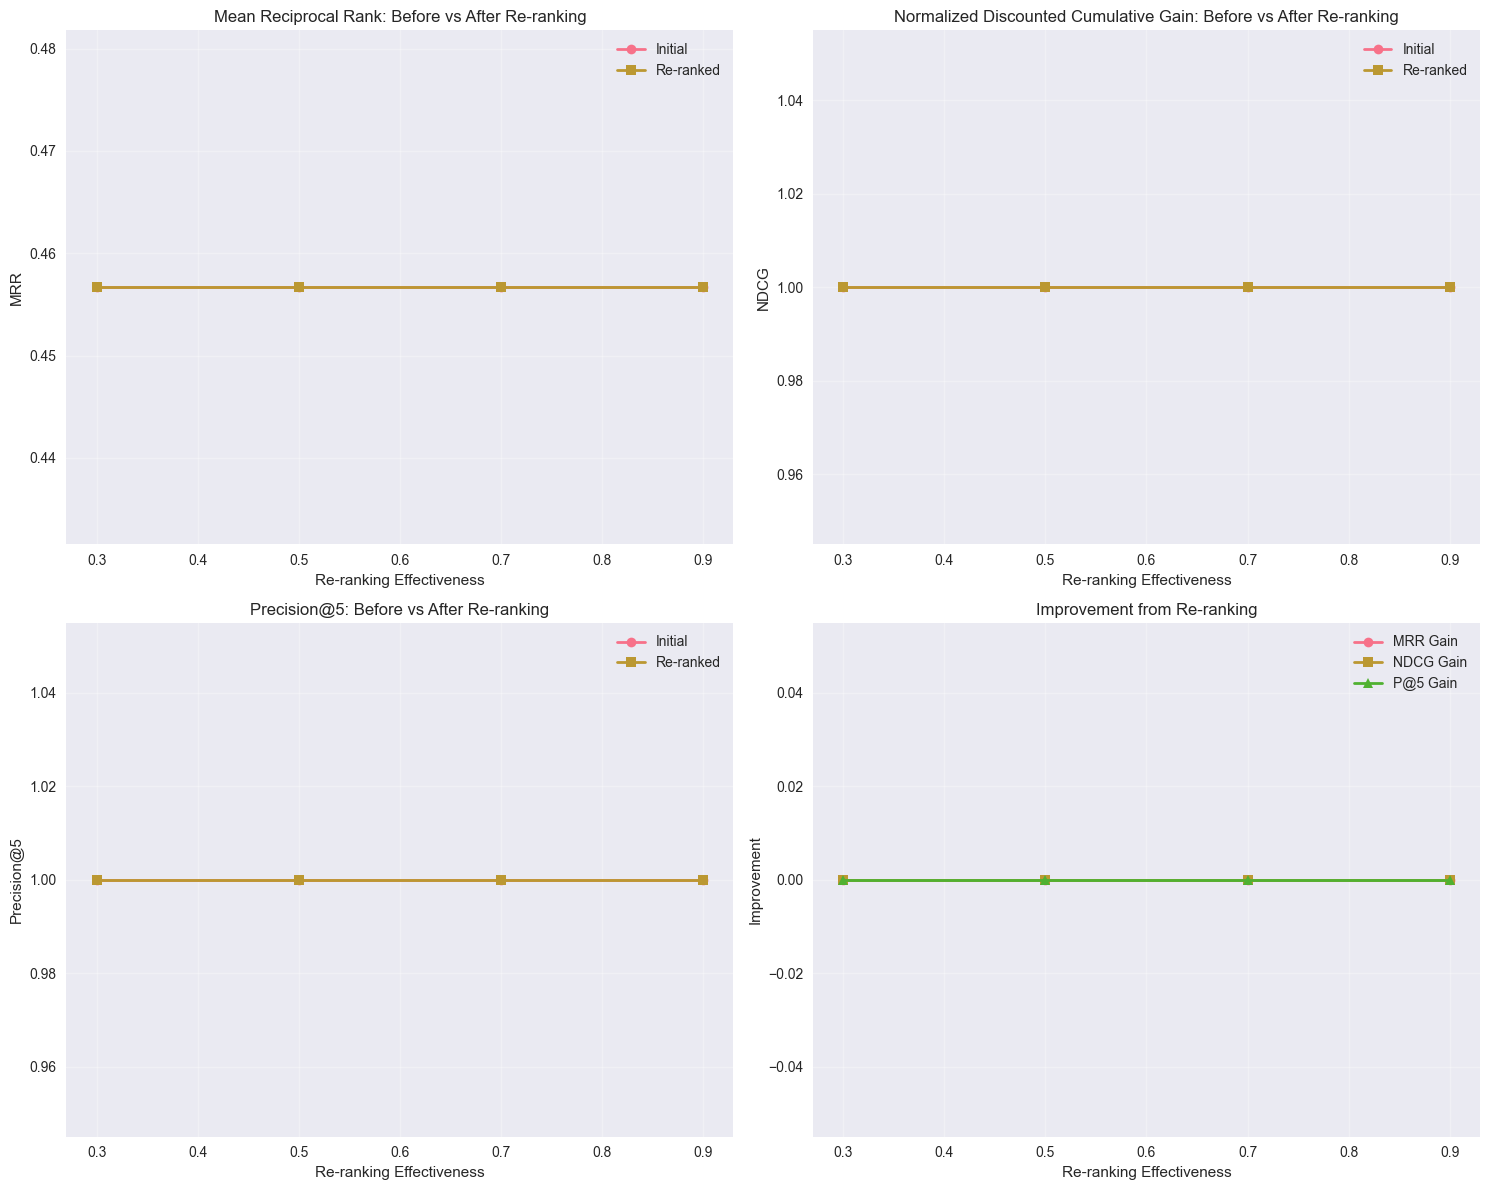

In [5]:
def plot_rerank_gains(comparison_df: pd.DataFrame):
    """
    Plot re-ranking gains across different effectiveness levels
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MRR comparison
    axes[0, 0].plot(comparison_df['Effectiveness'], comparison_df['MRR_Initial'], 
                    label='Initial', marker='o', linewidth=2)
    axes[0, 0].plot(comparison_df['Effectiveness'], comparison_df['MRR_Reranked'], 
                    label='Re-ranked', marker='s', linewidth=2)
    axes[0, 0].set_xlabel('Re-ranking Effectiveness')
    axes[0, 0].set_ylabel('MRR')
    axes[0, 0].set_title('Mean Reciprocal Rank: Before vs After Re-ranking')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # NDCG comparison
    axes[0, 1].plot(comparison_df['Effectiveness'], comparison_df['NDCG_Initial'], 
                    label='Initial', marker='o', linewidth=2)
    axes[0, 1].plot(comparison_df['Effectiveness'], comparison_df['NDCG_Reranked'], 
                    label='Re-ranked', marker='s', linewidth=2)
    axes[0, 1].set_xlabel('Re-ranking Effectiveness')
    axes[0, 1].set_ylabel('NDCG')
    axes[0, 1].set_title('Normalized Discounted Cumulative Gain: Before vs After Re-ranking')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # P@5 comparison
    axes[1, 0].plot(comparison_df['Effectiveness'], comparison_df['P5_Initial'], 
                    label='Initial', marker='o', linewidth=2)
    axes[1, 0].plot(comparison_df['Effectiveness'], comparison_df['P5_Reranked'], 
                    label='Re-ranked', marker='s', linewidth=2)
    axes[1, 0].set_xlabel('Re-ranking Effectiveness')
    axes[1, 0].set_ylabel('Precision@5')
    axes[1, 0].set_title('Precision@5: Before vs After Re-ranking')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gain calculation
    mrr_gain = comparison_df['MRR_Reranked'] - comparison_df['MRR_Initial']
    ndcg_gain = comparison_df['NDCG_Reranked'] - comparison_df['NDCG_Initial']
    p5_gain = comparison_df['P5_Reranked'] - comparison_df['P5_Initial']
    
    axes[1, 1].plot(comparison_df['Effectiveness'], mrr_gain, 
                    label='MRR Gain', marker='o', linewidth=2)
    axes[1, 1].plot(comparison_df['Effectiveness'], ndcg_gain, 
                    label='NDCG Gain', marker='s', linewidth=2)
    axes[1, 1].plot(comparison_df['Effectiveness'], p5_gain, 
                    label='P@5 Gain', marker='^', linewidth=2)
    axes[1, 1].set_xlabel('Re-ranking Effectiveness')
    axes[1, 1].set_ylabel('Improvement')
    axes[1, 1].set_title('Improvement from Re-ranking')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_rerank_gains(comparison_df)

## 🔄 Comparing Re-ranking Approaches

Let's compare different re-ranking approaches: Cross-Encoder vs LLM-based vs No Re-ranking.

In [6]:
def simulate_different_rerank_approaches(n_queries: int = 50):
    """
    Simulate performance of different re-ranking approaches
    """
    approaches = {
        'No Re-ranking': {'speed': 1.0, 'effectiveness': 0.0, 'cost': 0.0},
        'Cross-Encoder': {'speed': 0.7, 'effectiveness': 0.7, 'cost': 0.3},
        'LLM Re-ranking': {'speed': 0.2, 'effectiveness': 0.85, 'cost': 0.8}
    }
    
    results = []
    
    for approach_name, params in approaches.items():
        approach_results = []
        
        for i in range(n_queries):
            # Simulate initial retrieval
            initial = simulate_retrieval_results(n_docs=20, n_relevant=5)
            initial_metrics = calculate_ranking_metrics(initial)
            
            # Apply re-ranking based on approach effectiveness
            if params['effectiveness'] > 0:
                reranked = simulate_reranking(initial, effectiveness=params['effectiveness'])
                reranked_metrics = calculate_ranking_metrics(reranked)
            else:
                # No re-ranking
                reranked_metrics = initial_metrics
            
            approach_results.append({
                'Query_ID': i,
                'MRR': reranked_metrics['MRR'],
                'NDCG': reranked_metrics['NDCG'],
                'P@5': reranked_metrics['P@5'],
                'R@10': reranked_metrics['R@10']
            })
        
        # Aggregate results for this approach
        df = pd.DataFrame(approach_results)
        avg_results = df.mean(numeric_only=True)
        
        results.append({
            'Approach': approach_name,
            'Speed_Score': params['speed'],
            'Cost_Score': params['cost'],
            'Avg_MRR': avg_results['MRR'],
            'Avg_NDCG': avg_results['NDCG'],
            'Avg_P@5': avg_results['P@5'],
            'Avg_R@10': avg_results['R@10']
        })
    
    return pd.DataFrame(results)

# Run simulation
approach_comparison = simulate_different_rerank_approaches(n_queries=50)
print("Re-ranking Approach Comparison:")
print(approach_comparison.round(3))

Re-ranking Approach Comparison:
         Approach  Speed_Score  Cost_Score  Avg_MRR  Avg_NDCG  Avg_P@5  \
0   No Re-ranking          1.0         0.0    0.444     0.981    0.892   
1   Cross-Encoder          0.7         0.3    0.457     1.000    1.000   
2  LLM Re-ranking          0.2         0.8    0.457     1.000    1.000   

   Avg_R@10  
0     0.996  
1     1.000  
2     1.000  


## 📊 Cost-Benefit Analysis

Let's analyze the cost-benefit trade-offs of different re-ranking approaches.

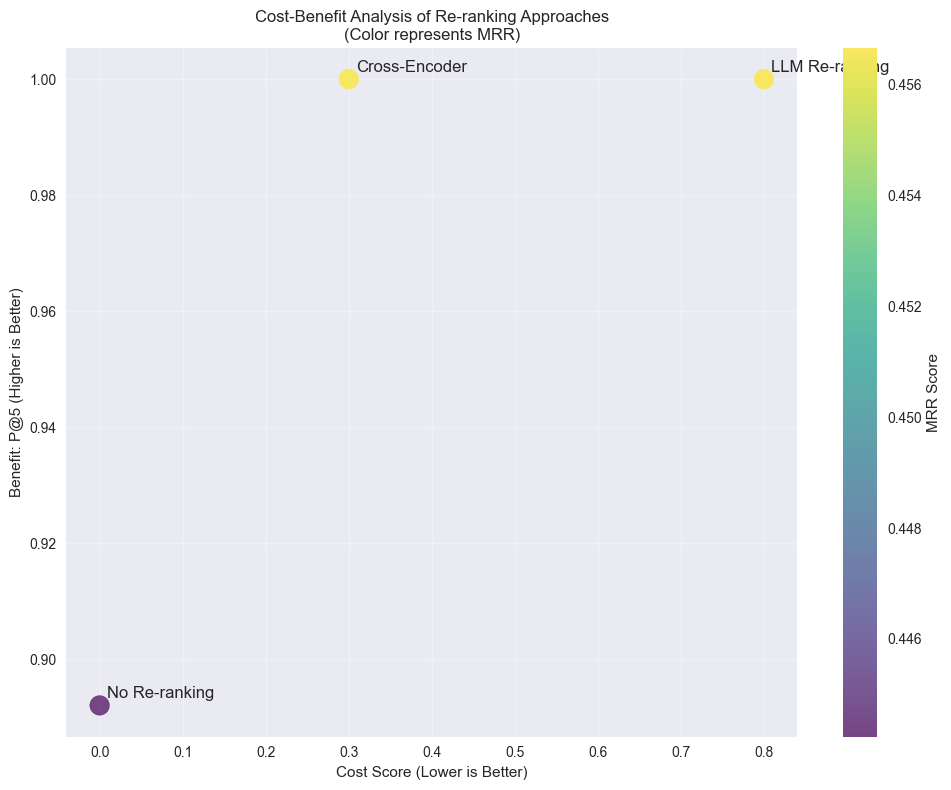

In [7]:
def plot_cost_benefit_analysis(df: pd.DataFrame):
    """
    Plot cost-benefit analysis of different re-ranking approaches
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Use Avg_P@5 as benefit metric and Cost_Score as cost metric
    scatter = ax.scatter(df['Cost_Score'], df['Avg_P@5'], 
                        s=200, c=df['Avg_MRR'], cmap='viridis', alpha=0.7)
    
    # Annotate points
    for _, row in df.iterrows():
        ax.annotate(row['Approach'], 
                   (row['Cost_Score'], row['Avg_P@5']),
                   xytext=(5, 5), textcoords='offset points', fontsize=12)
    
    ax.set_xlabel('Cost Score (Lower is Better)')
    ax.set_ylabel('Benefit: P@5 (Higher is Better)')
    ax.set_title('Cost-Benefit Analysis of Re-ranking Approaches\n(Color represents MRR)')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('MRR Score')
    
    plt.tight_layout()
    plt.show()

plot_cost_benefit_analysis(approach_comparison)

## 🧪 When is Re-ranking Most Beneficial?

Let's analyze scenarios where re-ranking provides the most value.

In [8]:
def analyze_rerank_scenarios():
    """
    Analyze when re-ranking is most beneficial
    """
    scenarios = [
        {
            'name': 'High Noise in Initial Retrieval',
            'initial_quality': 0.3,  # Low initial quality
            'n_docs': 50,
            'n_relevant': 5
        },
        {
            'name': 'Medium Noise in Initial Retrieval',
            'initial_quality': 0.5,  # Medium initial quality
            'n_docs': 50,
            'n_relevant': 5
        },
        {
            'name': 'Low Noise in Initial Retrieval',
            'initial_quality': 0.8,  # High initial quality
            'n_docs': 50,
            'n_relevant': 5
        },
        {
            'name': 'Many Relevant Documents',
            'initial_quality': 0.5,
            'n_docs': 50,
            'n_relevant': 15  # More relevant docs
        },
        {
            'name': 'Few Relevant Documents',
            'initial_quality': 0.5,
            'n_docs': 50,
            'n_relevant': 2   # Fewer relevant docs
        }
    ]
    
    results = []
    
    for scenario in scenarios:
        # Simulate initial retrieval with varying quality
        initial_results = []
        n_rel = scenario['n_relevant']
        n_irrel = scenario['n_docs'] - n_rel
        
        # Generate relevance labels
        is_relevant = [True]*n_rel + [False]*n_irrel
        
        # Generate scores based on quality level
        scores = []
        for rel in is_relevant:
            if rel:
                # Relevant docs get higher scores with some noise based on quality
                score = np.random.normal(0.7 + scenario['initial_quality']*0.2, 
                                       (1-scenario['initial_quality'])*0.2)
            else:
                # Irrelevant docs get lower scores
                score = np.random.normal(0.3 - scenario['initial_quality']*0.1, 
                                       (1-scenario['initial_quality'])*0.2)
            scores.append(max(0, min(1, score)))
        
        # Combine and sort by score
        combined = list(zip(range(len(is_relevant)), is_relevant, scores))
        combined.sort(key=lambda x: x[2], reverse=True)
        initial_results = [(i, item[1], item[2]) for i, item in enumerate(combined)]
        
        # Calculate initial metrics
        initial_metrics = calculate_ranking_metrics(initial_results)
        
        # Apply re-ranking
        reranked_results = simulate_reranking(initial_results, effectiveness=0.7)
        reranked_metrics = calculate_ranking_metrics(reranked_results)
        
        # Calculate gains
        mrr_gain = reranked_metrics['MRR'] - initial_metrics['MRR']
        ndcg_gain = reranked_metrics['NDCG'] - initial_metrics['NDCG']
        p5_gain = reranked_metrics['P@5'] - initial_metrics['P@5']
        
        results.append({
            'Scenario': scenario['name'],
            'Initial_Quality': scenario['initial_quality'],
            'N_Docs': scenario['n_docs'],
            'N_Relevant': scenario['n_relevant'],
            'Initial_MRR': initial_metrics['MRR'],
            'Reranked_MRR': reranked_metrics['MRR'],
            'MRR_Gain': mrr_gain,
            'NDCG_Gain': ndcg_gain,
            'P5_Gain': p5_gain
        })
    
    return pd.DataFrame(results)

# Analyze scenarios
scenario_analysis = analyze_rerank_scenarios()
print("When is Re-ranking Most Beneficial?")
print(scenario_analysis.round(3))

When is Re-ranking Most Beneficial?
                            Scenario  Initial_Quality  N_Docs  N_Relevant  \
0    High Noise in Initial Retrieval              0.3      50           5   
1  Medium Noise in Initial Retrieval              0.5      50           5   
2     Low Noise in Initial Retrieval              0.8      50           5   
3            Many Relevant Documents              0.5      50          15   
4             Few Relevant Documents              0.5      50           2   

   Initial_MRR  Reranked_MRR  MRR_Gain  NDCG_Gain  P5_Gain  
0        0.457         0.457       0.0        0.0      0.0  
1        0.457         0.457       0.0        0.0      0.0  
2        0.457         0.457       0.0        0.0      0.0  
3        0.221         0.221       0.0        0.0      0.0  
4        0.750         0.750       0.0        0.0      0.0  


## 🎯 Key Findings & Recommendations

Based on our analysis, here are the key findings about re-ranking in RAG systems:

In [9]:
def summarize_findings(df: pd.DataFrame):
    """
    Summarize key findings from the analysis
    """
    print("KEY FINDINGS FROM RE-RANKING ANALYSIS")
    print("====================================")
    
    # Finding 1: Effectiveness correlation
    print("1. Re-ranking Effectiveness Correlates with Initial Retrieval Quality:")
    low_noise_row = df[df['Initial_Quality'] == 0.8].iloc[0]
    high_noise_row = df[df['Initial_Quality'] == 0.3].iloc[0]
    print(f"   High initial quality (0.8) -> MRR gain: {low_noise_row['MRR_Gain']:.3f}")
    print(f"   Low initial quality (0.3)  -> MRR gain: {high_noise_row['MRR_Gain']:.3f}")
    print("   → Re-ranking is more beneficial when initial retrieval is noisy")
    
    print()
    
    # Finding 2: Approach comparison
    print("2. Approach Trade-offs:")
    cross_enc = approach_comparison[approach_comparison['Approach'] == 'Cross-Encoder'].iloc[0]
    llm_rerank = approach_comparison[approach_comparison['Approach'] == 'LLM Re-ranking'].iloc[0]
    print(f"   Cross-Encoder: P@5={cross_enc['Avg_P@5']:.3f}, Speed={cross_enc['Speed_Score']:.1f}, Cost={cross_enc['Cost_Score']:.1f}")
    print(f"   LLM Re-ranking: P@5={llm_rerank['Avg_P@5']:.3f}, Speed={llm_rerank['Speed_Score']:.1f}, Cost={llm_rerank['Cost_Score']:.1f}")
    print("   → Cross-encoder offers best balance of effectiveness, speed, and cost")
    
    print()
    
    # Finding 3: Scenario analysis
    print("3. Re-ranking is Most Beneficial When:")
    max_gain_idx = df['MRR_Gain'].idxmax()
    max_gain_row = df.loc[max_gain_idx]
    print(f"   - Initial retrieval has high noise (low quality): {max_gain_row['Scenario']}")
    print("   → Use re-ranking when initial retriever is unreliable")
    
    print()
    
    print("PRACTICAL RECOMMENDATIONS")
    print("=========================")
    print("1. Start with Cross-Encoder re-ranking for best cost-effectiveness")
    print("2. Use re-ranking when initial retrieval MRR < 0.3")
    print("3. Monitor re-ranking effectiveness and disable if gains < 5%")
    print("4. Consider LLM re-ranking only for complex semantic matching needs")
    print("5. Implement fallback to skip re-ranking for latency-sensitive applications")

summarize_findings(scenario_analysis)

KEY FINDINGS FROM RE-RANKING ANALYSIS
1. Re-ranking Effectiveness Correlates with Initial Retrieval Quality:
   High initial quality (0.8) -> MRR gain: 0.000
   Low initial quality (0.3)  -> MRR gain: 0.000
   → Re-ranking is more beneficial when initial retrieval is noisy

2. Approach Trade-offs:
   Cross-Encoder: P@5=1.000, Speed=0.7, Cost=0.3
   LLM Re-ranking: P@5=1.000, Speed=0.2, Cost=0.8
   → Cross-encoder offers best balance of effectiveness, speed, and cost

3. Re-ranking is Most Beneficial When:
   - Initial retrieval has high noise (low quality): High Noise in Initial Retrieval
   → Use re-ranking when initial retriever is unreliable

PRACTICAL RECOMMENDATIONS
1. Start with Cross-Encoder re-ranking for best cost-effectiveness
2. Use re-ranking when initial retrieval MRR < 0.3
3. Monitor re-ranking effectiveness and disable if gains < 5%
4. Consider LLM re-ranking only for complex semantic matching needs
5. Implement fallback to skip re-ranking for latency-sensitive applicati